In [165]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# import bond_pricing 
import numpy_financial as npf
import bond_pricing as bp

In [166]:
# import bond closing price data
dataframe = pd.read_csv('bond_close.csv')
# visualize the data:
dataframe
# Let's pick out 10 bonds, and since we want to plot the 5-year Yield curve, we will only use bonds with maturityday before 1/1/2029
# we will also pick bonds evenly distributed with maturity date with half year gap, 
# since government of Canada issues all of its bonds with a semi-annual coupon
dataframe['Maturity Date'] = pd.to_datetime(dataframe['Maturity Date'])
# keep bonds with maturity date before 1/1/2029
dataframe = dataframe[dataframe['Maturity Date'] <= '2029-3-1']
dataframe = dataframe[(dataframe['Maturity Date'].dt.month == 3) | (dataframe['Maturity Date'].dt.month == 9)]
# the bond that matures in March of 2024 is too close to maturity so we choose the other 10. 
dataframe = dataframe[dataframe['Maturity Date'] != '2024-3-1']
dataframe_sorted = dataframe.sort_values(by="Maturity Date")

In [179]:

# we have a our clean price in the dataframe
clean_price = dataframe_sorted.iloc[:, 4 : 16]
clean_price

# Create a list of closing dates
lst_date = []
for date in clean_price:
  lst_date.append(date)

# Create a copy of the dataframe for dirty price
dirty_price_df = dataframe_sorted.copy()

# Create a dataframe of dirty prices
for index in dataframe_sorted.index:
  for date in lst_date:
    date_time = pd.to_datetime(date)

    # Currently we have the closing prices as clean price, and we wish to find each bond's last coupon payment date
    clean_price = dataframe_sorted[date][index]
    coupon_rate = float(dataframe_sorted['Coupon'][index].strip('%'))

    # Since coupon payment is paid semi-annually, we have:
    accured_interest = ((date_time - pd.to_datetime(str(date_time.year - 1) + '-09/-1')).days / 365) * coupon_rate
    # Calculate the dirty price:
    new_price = accured_interest + clean_price
    dirty_price_df[date][index] = new_price
dirty_price_df
price_columns = dataframe_sorted.columns.tolist()[-11:]
price_columns

/var/folders/qz/lwgtdmfx4kj1cpw06sz1b21r0000gn/T/ipykernel_9702/2018243846.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dirty_price_df[date][index] = new_price
/var/folders/qz/lwgtdmfx4kj1cpw06sz1b21r0000gn/T/ipykernel_9702/201824384

['2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-15',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-22']

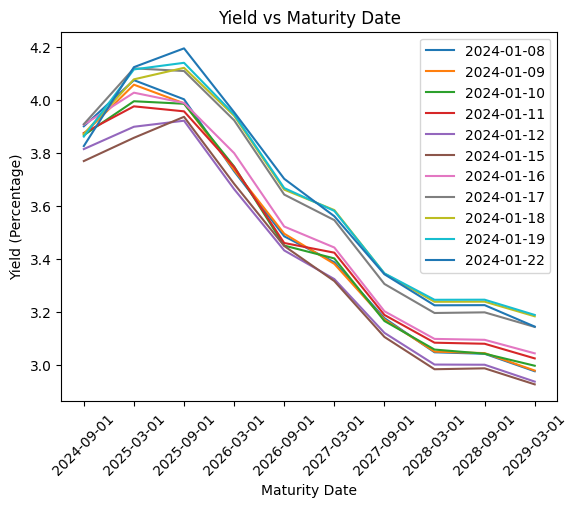

In [227]:
# Calculating ytm
lst_ymt = []

for date in lst_date:
  temp_lst = []
  for index in dirty_price_df.index:
    coupon_rate = float(dirty_price_df['Coupon'][index].strip('%'))
    maturity_date = dirty_price_df['Maturity Date'][index]
    time_to_maturity = (maturity_date - pd.to_datetime(date)).days / 365 
    price = float(dirty_price_df[date][index]) * -1
    ytm = npf.rate(nper = time_to_maturity, pmt = coupon_rate, pv = price, fv = 100)
    temp_lst.append((str(maturity_date.date()), ytm))
  lst_ymt.append((date, temp_lst))
lst_ymt
# now we plot the data
for line in lst_ymt:
  x = [i[0] for i in line[1]]
  y = [i[1] * 100 for i in line[1]]
  plt.plot(x, y, label=line[0])
  plt.xlabel('Maturity Date')
  plt.ylabel('Yield (Percentage)')
  plt.title('Yield vs Maturity Date')
  plt.xticks(rotation=45)
  plt.legend()
